In [1]:
import numpy as np
import time
import matplotlib.pyplot as plt
import scipy.integrate
# import function_conv as fc

# Discretization

In [2]:
def compute_U(D:np.array,
              E:np.array,
              W:np.array): 
    
    aux = D*E
    
    sub_diag = aux[1:-1]
    diag = -aux[:-1]-aux[1:]
    sup_diag = aux[1:-1]

    return W*(np.diag(sub_diag,k=-1)+np.diag(diag,k=0)+np.diag(sup_diag,k=1))

def compute_V(D:np.array,
              E:np.array,
              W:np.array,
              J:np.array): 
    
    aux = D*E
    
    sub_diag = J[2:-1]*aux[1:-1]
    diag = J[:-2]*aux[:-1]-J[2:]*aux[1:]
    sup_diag = -J[1:-2]*aux[1:-1]

    return W*(np.diag(sub_diag,k=-1)+np.diag(diag,k=0)+np.diag(sup_diag,k=1))

def compute_B_U_coefs(D:np.array,
                      E:np.array,
                      W:np.array):

    return W[0,0]*D[0]*E[0], W[-1,0]*D[-1]*E[-1]

def compute_B_V_coefs(D:np.array,
                      E:np.array,
                      W:np.array,
                      J:np.array):

    return J[1]*W[0,0]*D[0]*E[0], -J[-2]*W[-1,0]*D[-1]*E[-1]

In [3]:
def build_geometry(N:int,
                   sizes:np.array,
                   cw=4180.,
                   rhow=1000.):
    
    if len(sizes)!=N+2:
        print('non valid number of given cells sizes')
        
    else:
        D_U = 2*(sizes[:-1] + sizes[1:])**(-1)
        D_V = cw*rhow*(sizes[:-1] + sizes[1:])**(-1)
        e = np.zeros((N,2))
        e[0,0] = 1.
        e[N-1,1] = 1.
        
        return sizes, D_U, D_V, e

def build_W(C,J):
    
    return ((C*J[1:-1])**(-1)).reshape(len(C),1)

def build_E_V(K:np.array,
              D:np.array,
              H:np.array):
    
    return -K*D*(H[1:]-H[:-1])

def build_B_U(coefs_B_U:np.array,
              e:np.array,
              Yb:np.array):
    
    return coefs_B_U[0]*Yb[0]*e[:,0] + coefs_B_U[1]*Yb[1]*e[:,1]

def build_B_V(D:np.array,
              E:np.array,
              W:np.array,
              J:np.array,
              e:np.array,
              Yb:np.array):
    
    coef0, coef1 = compute_B_V_coefs(D,E,W,J)
    
    return coef0*Yb[0]*e[:,0] + coef1*Yb[1]*e[:,1]

def args_for_F_all(N:int,
               sizes:np.array,
               C_T:np.array,
               C_H:np.array,
               Lambda:np.array,
               K:np.array):
    
    J, D_U, D_V, e = build_geometry(N,sizes)
    
    W_T = build_W(C_T,J)
    W_H = build_W(C_H,J)
    
    U_T = compute_U(D_U,Lambda,W_T)
    U_H = compute_U(D_U,K,W_H)
    
    coefs_B_U_T = compute_B_U_coefs(D_U,Lambda,W_T)
    coefs_B_U_H = compute_B_U_coefs(D_U,K,W_H)
    
    return U_T, U_H, coefs_B_U_T, coefs_B_U_H, D_V, W_T

def F_all(U_T:np.array,
          U_H:np.array,
          coefs_B_U_T:np.array,
          coefs_B_U_H:np.array,
          D_U:np.array,
          D_V:np.array,
          W_T:np.array,
          K:np.array,
          J:np.array,
          e:np.array,
          Tb,
          Hb):
    
    def f(t,X):
        
        T = X[:len(K)-1]
        H = X[len(K)-1:]
        H_b = Hb(t)
        forHz = np.concatenate((np.array([H_b[0]]),H,np.array([H_b[1]])))
        
        E_V_T = build_E_V(K,D_U,forHz)
        V_T = compute_V(D_V,E_V_T,W_T,J)
        B_V_T = build_B_V(D_V,E_V_T,W_T,J,e,Tb(t))
        
        B_U_T = build_B_U(coefs_B_U_T,e,Tb(t))
        B_U_H = build_B_U(coefs_B_U_H,e,Hb(t))
        
        A_T = U_T + V_T
        B_T = B_U_T + B_V_T
        
        A_H = U_H
        B_H = B_U_H
        
        Tdot = np.dot(A_T,T) + B_T
        Hdot = np.dot(A_H,H) + B_H
        
        return np.concatenate((Tdot,Hdot))
    
    return f

# ODE

## RKF45

In [4]:
def RK5coefs(f,
             y:np.array,
             t:np.float64,
             h:np.float64):
    
    k = np.empty((len(y),6))
    
    k[:,0] = h*f(t,y)
    k[:,1] = h*f(t+1/4*h,y+1/4*k[:,0])
    k[:,2] = h*f(t+3/8*h,y+3/32*k[:,0]+9/32*k[:,1])
    k[:,3] = h*f(t+12/13*h,y+1932/2197*k[:,0]-7200/2197*k[:,1]+7296/2197*k[:,2])
    k[:,4] = h*f(t+h,y+439/216*k[:,0]-8*k[:,1]+3680/513*k[:,2]-845/4104*k[:,3])
    k[:,5] = h*f(t+1/2*h,y-8/27*k[:,0]+2*k[:,1]-3544/2565*k[:,2]+1859/4104*k[:,3]-11/40*k[:,4])
    
    

    return k

def step_scaler(k:np.array,
                tol:np.float64,
                RK4_cok:np.array,
                RK5_cok:np.array):
    
    twoN = len(k)
    s_T = (tol/(2*np.linalg.norm(np.dot(k[:twoN//2,:],RK5_cok-RK4_cok))))**(1/4)
    s_H = (tol/(2*np.linalg.norm(np.dot(k[twoN//2:,:],RK5_cok-RK4_cok))))**(1/4)
    
    return min(s_T,s_H)

def RKF45(f,
          y0:np.array,
          t0:np.float64,
          tf:np.float64,
          h:np.float64,
          tol:np.float64,
          RK4_cok:np.array,
          RK5_cok:np.array,
          RK5_cok_vec:np.array):
    
    t = t0
    
    while t<tf:
        
        k0 = RK5coefs(f,y0,t,h)
        
        h = h*step_scaler(k0,tol,RK4_cok,RK5_cok)
        if t+h>tf:
            h = tf-t
        t = t + h
        
        k1 = RK5coefs(f,y0,t,h)       
        y0 = y0 + np.dot(k1,RK5_cok_vec)
        
    return y0

## Solver

In [5]:
def timefunction(C:np.array,
                 dt:float,
                 t0:float,
                 tf:float):
    
    def f(t:float):
        if t<t0:
            return C[0]
        elif t>=tf:
            return C[-1]
        else:
            n,e = np.divmod(t-t0,dt)
            n = int(n)
            return (1-e/dt)*C[n] + e/dt*C[n+1]
    
    return f

In [6]:
def solver(f,
           y0:np.array,
           t0:float,
           tol:float,
           fsample,
           times:np.array,
           h=1,
           method='RKF45'):
    
    samples = np.empty((len(fsample(y0)),len(times)))
    
    if method=='RKF45':
        
        RK4_cok_vec = np.array([25/216,0,1408/2565,2197/4101,-1/5,0],dtype=np.float64)
        RK5_cok_vec = np.array([16/135,0,6656/12825,28561/56430,-9/50,2/55],dtype=np.float64)
        RK4_cok = RK4_cok_vec.reshape(6,1)
        RK5_cok = RK5_cok_vec.reshape(6,1)
    
        for i,t in enumerate(times):

            y1 = RKF45(f,y0,t0,t,h,tol,RK4_cok,RK5_cok,RK5_cok_vec)
            
            y0 = y1
            
            t0 = t
            
            samples[:,i] = fsample(y0)
        
        return samples
    
    else:
        
        print('unkown method')

# test

In [7]:
def build_depths_and_sizes(h,N):

    l = h/(N+1)    
    sizes = l*np.ones(N+2)
    Zmeas = np.empty(N)
    Zmeas[0] = (sizes[0] + sizes[1])/2
    for i in range(1,N):
        Zmeas[i] = Zmeas[i-1] + (sizes[i] + sizes[i+1])/2
        
    return Zmeas, sizes

def steady_state_test(t0,tf,Tss,Hss,h,T0,H0,N,K,Lambda,C,S,tol):
    
    Tb = timefunction(Tss,tf,t0,tf)
    Hb = timefunction(Hss,tf,t0,tf)
    
    Zmeas, sizes = build_depths_and_sizes(h,N)
    
    J, D_U, D_V, e = build_geometry(N,sizes)
    U_T, U_H, coefs_B_U_T, coefs_B_U_H, D_V, W_T = args_for_F_all(N,sizes,C,S,Lambda,K)
    f = F_all(U_T,U_H,coefs_B_U_T,coefs_B_U_H,D_U,D_V,W_T,K,J,e,Tb,Hb)
    
    y0 = np.concatenate((T0,H0))    
    def fsample(y:np.array):
        return y
    
    return solver(f,y0,t0,tol,fsample,np.array([tf]),h=tf/10)

def homgeneous_test(tf,Tss,Hss,h,N,T0,H0,tol,
                    k_ref=10**(-5),
                    lambda_ref=3,
                    c_ref=4*10**(6),
                    s_ref=0.2,
                    cw = 4180.,
                    rhow = 1000.,
                    display=False):
    t0 = 0
    K = k_ref*np.ones(N+1)
    Lambda = lambda_ref*np.ones(N+1)
    C = c_ref*np.ones(N)
    S = s_ref*np.ones(N)
    
    result = steady_state_test(t0,tf,np.array([Tss,Tss]),np.array([Hss,Hss]),h,T0,H0,N,K,Lambda,C,S,tol)
    
    T_res = result[:N]
    H_res = result[N:]
    
    Zmeas, _ = build_depths_and_sizes(h,N)
    
    H_exact = (Hss[1]-Hss[0])/h*Zmeas+Hss[0]
    
    gamma = -cw*rhow*k_ref*(Hss[1]-Hss[0])/(h*lambda_ref)
    alpha = (Tss[0]-Tss[1])/(1-np.exp(gamma*h))
    beta = (Tss[1]-Tss[0]*np.exp(gamma*h))/(1-np.exp(gamma*h))
    T_exact = np.exp(gamma*Zmeas)*alpha+beta
    
    if display:
    
        plt.figure()
        plt.scatter(Zmeas,T_res,label='computed')
        plt.plot(Zmeas,T_exact,label='exact')
        plt.xlabel('depth [m]')
        plt.ylabel('temperature [K]')
        plt.legend()
        plt.show()    

        plt.figure()
        plt.scatter(Zmeas,H_res,label='computed')
        plt.plot(Zmeas,H_exact,label='exact')
        plt.xlabel('depth [m]')
        plt.ylabel('hydraulic charge [H]')
        plt.legend()
        plt.show()
    
    return np.max(abs(T_res.reshape(T_exact.shape)-T_exact)), np.max(abs(H_res.reshape(H_exact.shape)-H_exact))

def heterogeneous_test(tf,Tss,Hss,h,N,T0,H0,tol,
                       kz_ref = 10**(-5),
                       k_ref = 10**(-5),
                       lambda_ref=3,
                       c_ref=4*10**(6),
                       s_ref=0.2,
                       cw = 4180.,
                       rhow = 1000.,
                       display=False):
    t0 = 0
    Zmeas, sizes = build_depths_and_sizes(h,N)
    ZK = Zmeas-sizes[0]/2
    ZK = np.concatenate((ZK,np.array([ZK[-1]+sizes[0]/2])))
    K = kz_ref*ZK + k_ref
    Lambda = lambda_ref*np.ones(N+1)
    C = c_ref*np.ones(N)
    S = s_ref*np.ones(N)
    
    result = steady_state_test(t0,tf,np.array([Tss,Tss]),np.array([Hss,Hss]),h,T0,H0,N,K,Lambda,C,S,tol)
    
    T_res = result[:N]
    H_res = result[N:]
    
    fK = lambda z : kz_ref*z + k_ref
    fH = lambda z :(Hss[1]-Hss[0])*(np.log(kz_ref*z+k_ref)-np.log(k_ref))/(np.log(kz_ref*h+k_ref)-np.log(k_ref))+Hss[0]
    fHz = lambda z : kz_ref*(Hss[1]-Hss[0])/((np.log(kz_ref*h+k_ref)-np.log(k_ref))*(kz_ref*z+k_ref))
    
    H_exact = np.vectorize(fH)(Zmeas)
    
    T_exact = np.empty(N)
    aux = lambda z : np.exp(-cw*rhow*fK(z)*fHz(z)*z/lambda_ref)
    
    normalizer = scipy.integrate.quad(aux,0,h)[0]
    for i,z in enumerate(Zmeas):
        T_exact[i] = (Tss[1]-Tss[0])*scipy.integrate.quad(aux,0,z)[0]/normalizer+Tss[0]
    
    if display:
    
        plt.figure()
        plt.scatter(Zmeas,T_res,label='computed')
        plt.plot(Zmeas,T_exact,label='exact')
        plt.xlabel('depth [m]')
        plt.ylabel('temperature [K]')
        plt.legend()
        plt.show()    

        plt.figure()
        plt.scatter(Zmeas,H_res,label='computed')
        plt.plot(Zmeas,H_exact,label='exact')
        plt.xlabel('depth [m]')
        plt.ylabel('hydraulic charge [H]')
        plt.legend()
        plt.show()
    
    return np.max(abs(T_res.reshape(T_exact.shape)-T_exact)), np.max(abs(H_res.reshape(H_exact.shape)-H_exact))

In [8]:
tf = 1*24*3600
Tss = np.array([290.,300.])
Hss = np.array([0.05,0.])
htot = 0.4
N = 22
T0 = 295*np.ones(N)
H0 = 0.025*np.ones(N)
tol = 10**(-1)

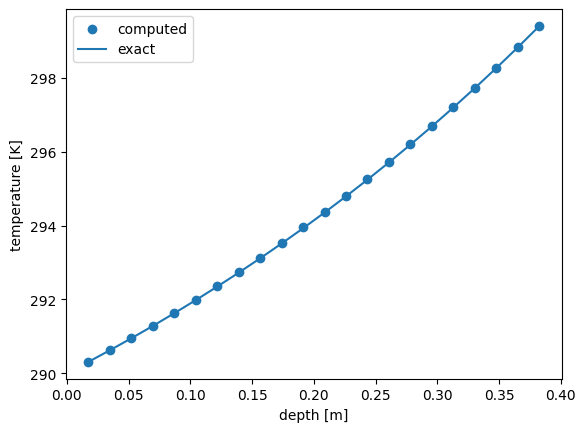

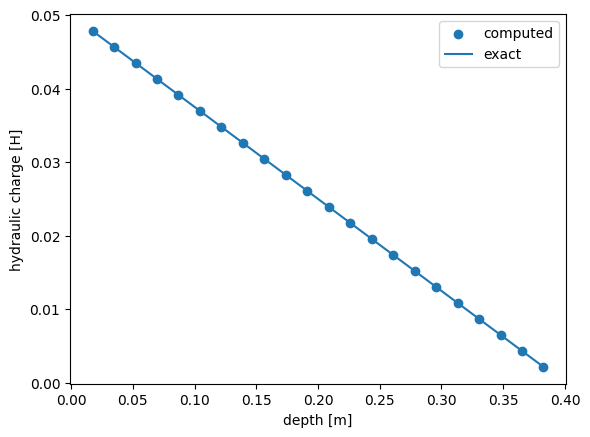

(0.022296887545394384, 2.0135172441128335e-05)


In [9]:
errors_homogeneous = homgeneous_test(tf,Tss,Hss,htot,N,T0,H0,tol,display=True)
print(errors_homogeneous)

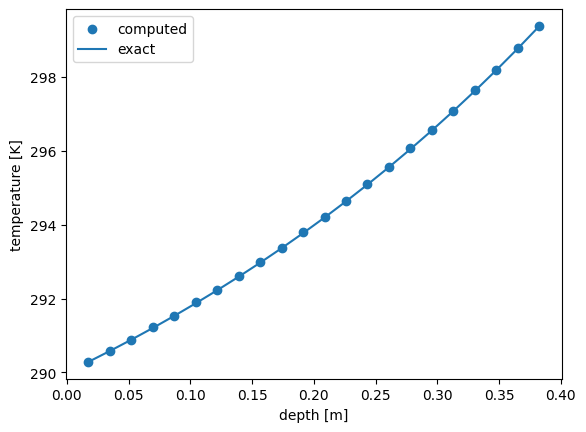

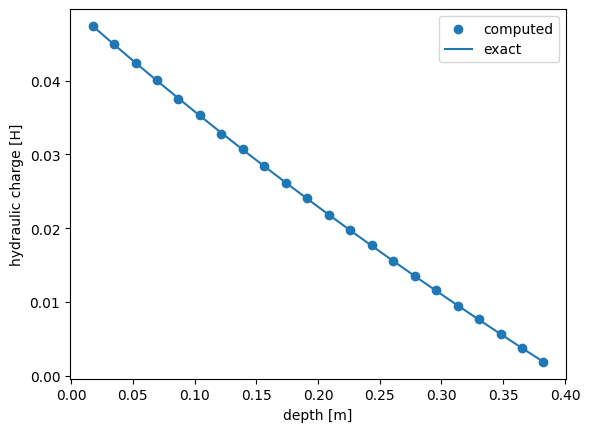

(0.028941250826562737, 0.0001326941577189612)


In [10]:
errors_heterogeneous = heterogeneous_test(tf,Tss,Hss,htot,N,T0,H0,tol,display=True)
print(errors_heterogeneous)